In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import ImageDataset
from torchvision import transforms
from utils import to_var, to_tensor, to_image
from models import Generator128, PatchGan
from torch.optim import Adam
from criterion import PatchGanLoss
import itertools

In [2]:
PATH = '/home/austin/data/horse2zebra/'
PATH_HORSES = PATH + 'trainA'
PATH_ZEBRAS = PATH + 'trainB'

In [3]:
transform = transforms.Compose([transforms.Scale(128),
                                transforms.CenterCrop(128),
                                transforms.ToTensor()])

In [4]:
horses = ImageDataset(PATH_HORSES, transforms=transform)
zebras = ImageDataset(PATH_ZEBRAS, transforms=transform)

horse_loader = DataLoader(horses, shuffle=True, batch_size=1)
zebra_loader = DataLoader(zebras, shuffle=True, batch_size=1)

In [5]:
len(horses), len(zebras)

(1067, 1334)

## Models
- Generator A, Generator B <--- same architecture resnet like Johnsonresnet or Unet 6 blocks for 128x128 9 blocks for 256x256
- Discriminator A, Discriminator B <-- PatchGANS


In [7]:
horse_to_zebra = Generator128()
horse_to_zebra.cuda()

zebra_to_horse = Generator128()
zebra_to_horse.cuda()

Generator128 (
  (conv_in): ConvBlock (
    (pad): ReflectionPad2d (3, 3, 3, 3)
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
    (activation): ReLU (inplace)
  )
  (encode1): ConvBlock (
    (pad): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    (activation): ReLU (inplace)
  )
  (encode2): ConvBlock (
    (pad): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (activation): ReLU (inplace)
  )
  (res1): ResBlock (
    (pad): ReflectionPad2d (1, 1, 1, 1)
    (conv3x3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (dropout): Dropout2d (p=0.5)
    (activation): ReLU (inplace)
  )
  (res2): 

In [8]:
zebra_discriminator = PatchGan()
zebra_discriminator.cuda()

horse_discriminator = PatchGan()
horse_discriminator.cuda()

PatchGan (
  (activation): LeakyReLU (0.2, inplace)
  (conv_in): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (layer_1): ConvBlock (
    (pad): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    (activation): LeakyReLU (0.2, inplace)
  )
  (layer_2): ConvBlock (
    (pad): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (activation): LeakyReLU (0.2, inplace)
  )
  (layer_3): ConvBlock (
    (pad): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False)
    (activation): LeakyReLU (0.2, inplace)
  )
  (conv_out): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

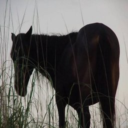

In [9]:
input_horse = to_var(horses[1]).unsqueeze(0)
to_image(horses[1])

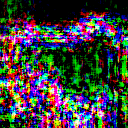

In [10]:
output_zebra = horse_to_zebra(input_horse)
to_image(to_tensor(output_zebra.squeeze(0)))

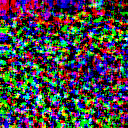

In [11]:
recovered_horse = zebra_to_horse(output_zebra)
to_image(to_tensor(recovered_horse.squeeze(0)))

In [12]:
g_params = itertools.chain(horse_to_zebra.parameters(), zebra_to_horse.parameters())
d_params = itertools.chain(horse_discriminator.parameters(), zebra_discriminator.parameters())

In [13]:
g_optimizer = Adam(g_params, lr=2e-3) # constant for 100 epochs, linear decay for 100 epochs
d_optimizer = Adam(d_params, lr=1e-3)

In [14]:
cycle_weight = 10
d_criterion = PatchGanLoss()
cycle_loss = nn.L1Loss() # cycle loss is just L1 loss between original image and reconstructed image

In [15]:
horse = next(iter(horse_loader))
zebra = next(iter(zebra_loader))

horse = to_var(horse)
zebra = to_var(zebra)

### Train discriminators
    - feed one real horse and one fake horse to horse d    
    - feed one real zebra and one fake zebra to zebra d
    - add up losses 
    - take one step with d optimizer
    
    - train discriminators with history of generated images?



In [16]:
# loss for horse discriminator
fake_horse = zebra_to_horse(zebra)
d_horse_batch = torch.cat([horse, fake_horse])
d_horse_targets = torch.Tensor([1, 0])
d_horse_score = horse_discriminator(d_horse_batch)
d_horse_loss = d_criterion(d_horse_score, d_horse_targets)

# loss for zebra discriminator
fake_zebra = horse_to_zebra(horse)
d_zebra_batch = torch.cat([zebra, fake_zebra])
d_zebra_targets = torch.Tensor([1, 0])
d_zebra_score = zebra_discriminator(d_zebra_batch)
d_zebra_loss = d_criterion(d_zebra_score, d_zebra_targets)


print(d_horse_loss.data, d_zebra_loss.data)

# add up losses
d_loss = d_horse_loss + d_zebra_loss

# take step
d_optimizer.zero_grad()
d_loss.backward()
d_optimizer.step()


 0.7357
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 
 0.7167
[torch.cuda.FloatTensor of size 1 (GPU 0)]



### Train Generators

### (horse to zebra cycle)
    - feed one horse to horse_to_zebra network to get fake zebra
    - feed fake zebra output to zebra discriminator to get adversarial score (we want this to be all ones)
    - feed fake zebra output to zebra_to_horse network to get reconstructed horse
    - check mse between reconstructed horse and original horse
    - add adversarial scores + mse reconstructed score , calc loss, take g_optimization step
    
### (zebra to horse cycle)
    - feed one zebra to zebra_to_horse network to get fake horse
    - feed fake horse output to horse discriminator to get horse adversarial score
    - feed fake horse output to horse_to_zebra network to get reconstructed zebra
    - check msee between reconstructed zebra and original zebra
    - add adversarial scores + mse reconstructed score , calc loss, take g_optimization step

In [17]:
d_loss_target = torch.Tensor([1]) # we now want the score for the generated animals to be one

fake_zebra = horse_to_zebra(horse)
d_zebra_score = zebra_discriminator(fake_zebra)
reconstructed_horse = zebra_to_horse(fake_zebra)
d_zebra_loss = d_criterion(d_zebra_score, d_loss_target)
horse_cycle_loss = cycle_loss(reconstructed_horse, horse)

In [18]:
fake_horse = zebra_to_horse(zebra)
d_horse_score = horse_discriminator(fake_horse)
reconstructed_zebra = horse_to_zebra(fake_horse)
d_horse_loss = d_criterion(d_horse_score, d_loss_target)
zebra_cycle_loss = cycle_loss(reconstructed_zebra, zebra)

In [19]:
g_loss = d_zebra_loss + d_horse_loss +  (cycle_weight * (zebra_cycle_loss + horse_cycle_loss))
g_loss

Variable containing:
 16.9615
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [20]:
g_optimizer.zero_grad()
g_loss.backward()
g_optimizer.step()